In [3]:
# Data handling
import pandas as pd
import numpy as np
import seaborn as sns

# Text preprocessing
import re
import string
import html
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import (
    classification_report, precision_recall_curve, 
    average_precision_score
)

# Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Explainability
!pip install shap
import shap

In [9]:
path='fake_job_postings.csv'
postings = pd.read_csv(path)
postings.head(3)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0


In [11]:
postings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [13]:
postings.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [15]:
columns_dropped = ['salary_range', 'department', 'benefits', 'required_experience', 'function', 'required_education']
postings_new = postings.drop(columns_dropped, axis=1)
postings_new.head(3)

,job_id,title,location,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,employment_type,industry,fraudulent
0,1,Marketing Intern,"US, NY, New York","We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,0,1,0,Other,NaN,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland","90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,0,1,0,Full-time,Marketing and Advertising,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,0,1,0,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",0,1,0,Full-time,Computer Software,0
4,5,Bill Review Manager,"US, FL, Fort Worth",SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,0,1,1,Full-time,Hospital & Health Care,0


In [17]:
postings_new['description'] = postings_new['description'].fillna("unknown")
postings_new = postings_new.drop_duplicates()

In [19]:
columns = ['title', 'location', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'industry', 'fraudulent']
for e in columns:
    print(e, postings_new[columns][e].value_counts().head())

title title
English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
Name: count, dtype: int64
location location
GB, LND, London          718
US, NY, New York         658
US, CA, San Francisco    472
GR, I, Athens            464
US, ,                    339
Name: count, dtype: int64
telecommuting telecommuting
0    17113
1      767
Name: count, dtype: int64
has_company_logo has_company_logo
1    14220
0     3660
Name: count, dtype: int64
has_questions has_questions
0    9088
1    8792
Name: count, dtype: int64
employment_type employment_type
Full-time    11620
Contract      1524
Part-time      797
Temporary      241
Other          227
Name: count, dtype: int64
industry industry
Information Technology and Services    1734
Computer Software                   

C:\Users\vetal\AppData\Local\Temp\ipykernel_20804\1519249000.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.barplot(
C:\Users\vetal\AppData\Local\Temp\ipykernel_20804\1519249000.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.barplot(


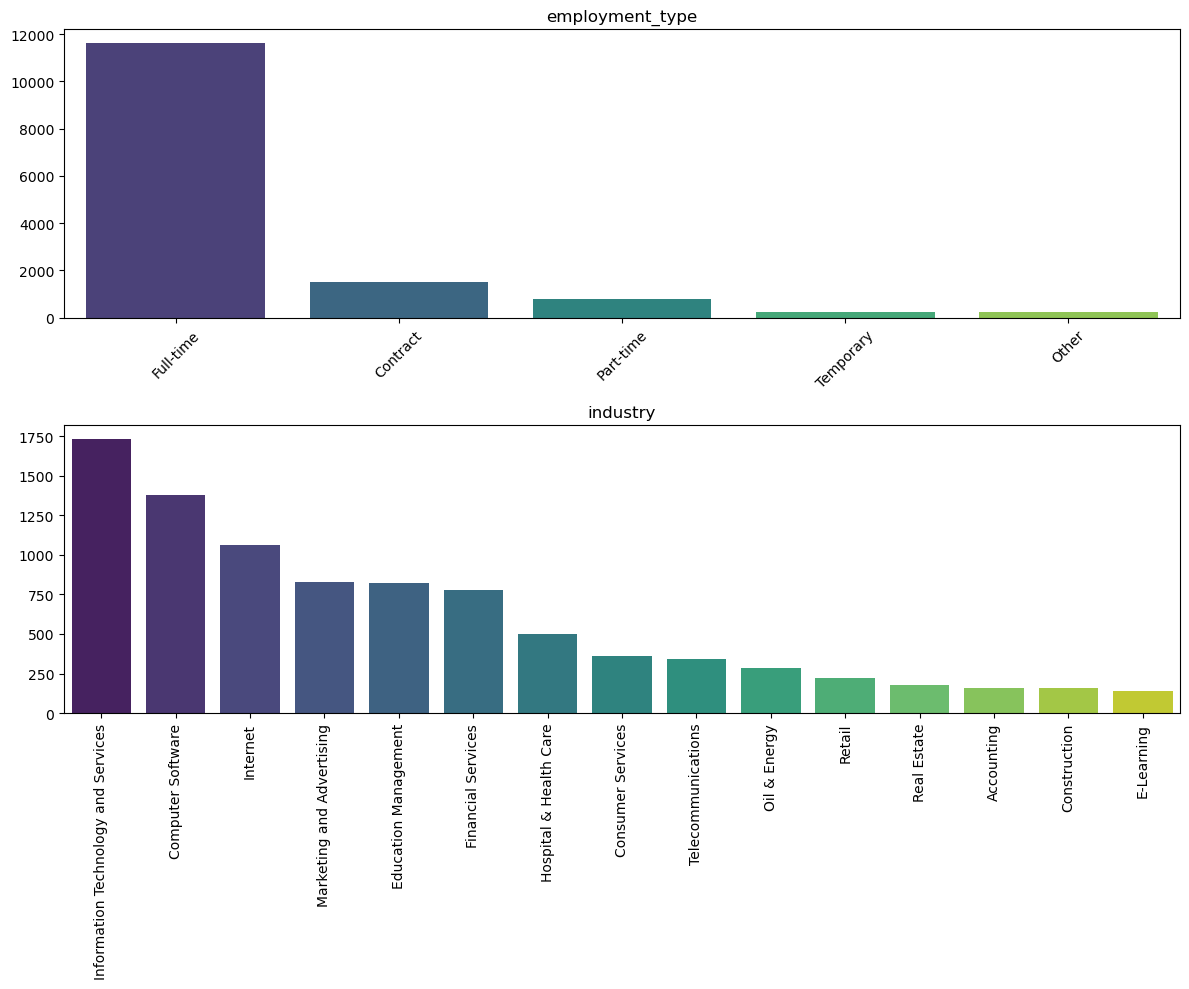

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

visualize = ['employment_type', 'industry']
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
j = 0

for col in visualize:
    ax_g = ax[j]

    # Get top 15 categories and their counts
    top_counts = postings_new[col].value_counts().iloc[:15]
    categories = top_counts.index
    counts = top_counts.values

    # Create a DataFrame for barplot
    bar_df = pd.DataFrame({col: categories, 'count': counts})

    # Define a colorful palette
    palette = sns.color_palette("viridis", len(categories))

    # Plot using barplot (manually created count data)
    chart = sns.barplot(
        data=bar_df,
        x=col,
        y='count',
        ax=ax_g,
        palette=palette
    )

    chart.tick_params(axis='x', rotation=90 if j == 1 else 45)
    ax_g.set_ylabel('')
    ax_g.set_xlabel('')
    ax_g.set_title(col, fontsize=12)
    j += 1

plt.tight_layout()
plt.show()


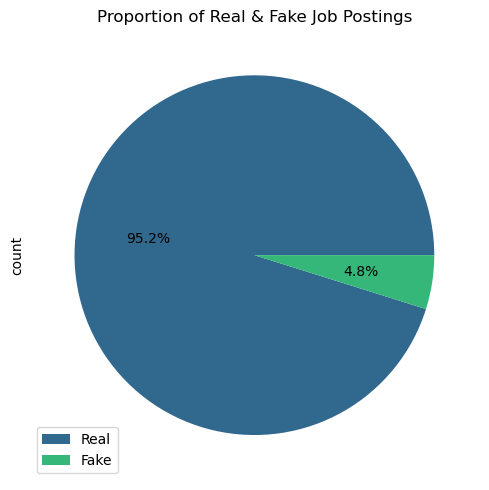

In [31]:
# Define labels and matching palette
labels = ["Real", "Fake"]
colors = sns.color_palette("viridis", len(labels))  # or "coolwarm", "plasma", etc.

# Plot pie chart
postings_new['fraudulent'].value_counts().plot.pie(
    figsize=(5, 5),
    title="Proportion of Real & Fake Job Postings",
    labels=["", ""],           # suppress labels on pie
    autopct='%1.1f%%',
    colors=colors              # 👈 apply custom palette
)

# Add legend
plt.legend(labels, loc=3)
plt.gca().set_aspect('equal')  # keeps it round
plt.tight_layout()
plt.show()

In [33]:
# Function to compute word count statistics for each category
def compute_text_stats(df, text_column, label_column):
    # Count number of words in each news article
    df["word_count"] = df[text_column].apply(lambda x: len(str(x).split()))

    # Group by label and compute stats
    stats = df.groupby(label_column)["word_count"].agg(["min", "max", "mean", "median"])

    return stats

# Compute stats for each dataset
my_stats = compute_text_stats(postings_new, "requirements", "fraudulent")

# Display results
print("Data Stats:\n", my_stats)

Data Stats:
             min   max       mean  median
fraudulent                              
0             0  1645  79.181262    63.0
1             1   471  58.585450    34.0


Should you use word count of requirements as a feature?
Yes, it’s a good idea to use it as a feature. Here's why:

✅ Signal exists: Real and fake postings have noticeably different word counts.

✅ Fast and simple: It’s easy to compute and doesn’t require complex preprocessing.

✅ Complementary: It adds value when combined with text-based features like TF-IDF or embeddings.

In [35]:
# Compute stats for each dataset
my_stats_d = compute_text_stats(postings_new, "description", "fraudulent")

# Display results
print("📊 Data Stats:\n", my_stats_d)

📊 Data Stats:
             min   max        mean  median
fraudulent                               
0             1  2115  171.041378   147.0
1             0  1183  158.749423   113.5


The difference in word count between real and fake job descriptions is smaller than in the requirements field, but still:

Real postings tend to be longer (on average).

Median is higher for real (147 vs. 113.5).

Max is much higher for real postings (2115 vs. 1183), which may suggest some especially detailed legit posts.

Yes — it's still useful even if the difference is smaller than for requirements. Here’s why:

✅ It’s a low-effort, high-signal feature.

✅ It might help your model distinguish underdeveloped fake postings from legitimate ones.

✅ Together with requirements_word_count, it gives your model more contextual information.

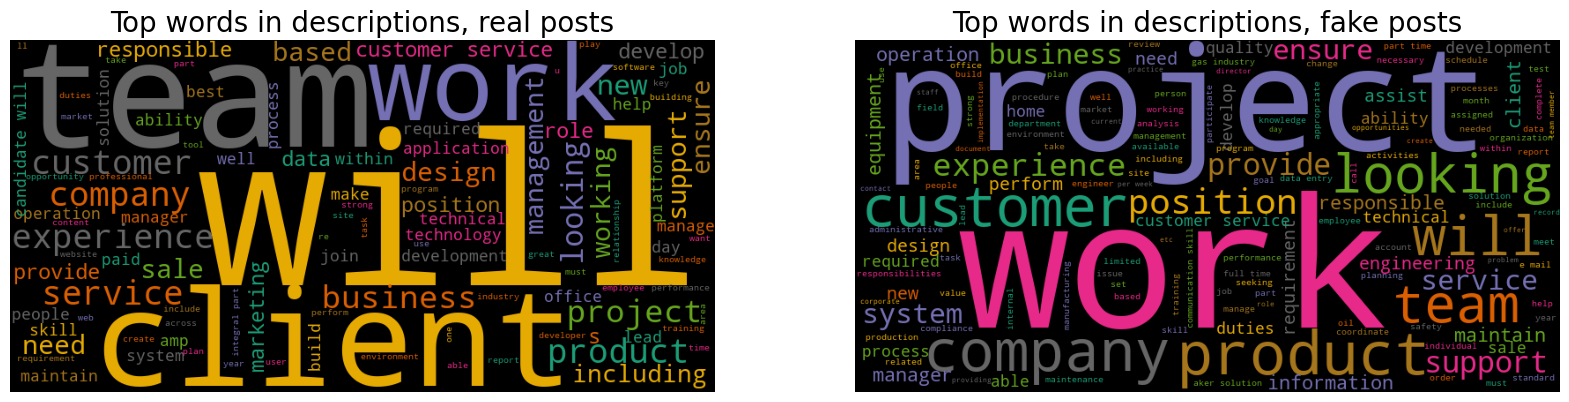

In [39]:
n_posts = 1000
q_S = ' '.join(postings_new[postings_new['fraudulent'] == 0]['description'].str.lower().values[:n_posts])
q_I = ' '.join(postings_new[postings_new['fraudulent'] == 1]['description'].str.lower().values[:n_posts])

wordcloud_S = WordCloud(max_font_size=None,scale = 2,colormap = 'Dark2').generate(q_S)
wordcloud_I = WordCloud(max_font_size=None,scale = 2,colormap = 'Dark2').generate(q_I)

fig, ax = plt.subplots(1,2, figsize=(20, 5))
ax[0].imshow(wordcloud_S)
ax[0].set_title('Top words in descriptions, real posts',fontsize = 20)
ax[0].axis("off")

ax[1].imshow(wordcloud_I)
ax[1].set_title('Top words in descriptions, fake posts',fontsize = 20)
ax[1].axis("off")

plt.show()

In [41]:
# First split: 80% train, 20% temp (val + test)
train_df, temp_df = train_test_split(
    postings_new,
    test_size=0.2,
    stratify=postings_new["fraudulent"],
    random_state=42
)

# Second split: 50% val, 50% test of the remaining 20% → each 10% of full data
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["fraudulent"],
    random_state=42
)

# Confirm the proportions
print("Train class distribution:\n", train_df["fraudulent"].value_counts(normalize=True))
print("Validation class distribution:\n", val_df["fraudulent"].value_counts(normalize=True))
print("Test class distribution:\n", test_df["fraudulent"].value_counts(normalize=True))

Train class distribution:
 fraudulent
0    0.951552
1    0.048448
Name: proportion, dtype: float64
Validation class distribution:
 fraudulent
0    0.951342
1    0.048658
Name: proportion, dtype: float64
Test class distribution:
 fraudulent
0    0.951902
1    0.048098
Name: proportion, dtype: float64


### Text Cleaning and TF-IDF Vectorization

In [44]:
# Load SpaCy model
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Customize stopword list
keep_stopwords = {"full", "part", "no", "any"}
custom_stopwords = STOP_WORDS - keep_stopwords

def clean_and_lemmatize(text):
    if not isinstance(text, str):
        return ""

    # Unescape HTML entities
    text = html.unescape(text)

    # Fix glued words like 'meetingsWorking' → 'meetings Working'
    text = re.sub(r"([a-z])([A-Z])", r"\1 \2", text)

    # Lowercase
    text = text.lower()

    # Remove URLs and HTML tags
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"<.*?>", "", text)

    # Normalize hyphens
    text = re.sub(r"[-–—]{2,}", " ", text)
    text = re.sub(r"\s*-\s*", "-", text)
    text = re.sub(r"\b-\b", " ", text)

    # Remove all punctuation except hyphen
    text = re.sub(f"[{re.escape(string.punctuation.replace('-', ''))}]", "", text)

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # Lemmatize and filter stopwords
    doc = nlp(text)
    lemmatized_text = " ".join([
        token.lemma_ for token in doc if token.text not in custom_stopwords
    ])

    return lemmatized_text

In [46]:
train_df["clean_description"] = train_df["description"].apply(clean_and_lemmatize)
val_df["clean_description"] = val_df["description"].apply(clean_and_lemmatize)
test_df["clean_description"] = test_df["description"].apply(clean_and_lemmatize)

In [52]:
train_df['description'][0]

'Food52, a fast-growing, James Beard Award-winning online food community and crowd-sourced and curated recipe hub, is currently interviewing full- and part-time unpaid interns to work in a small team of editors, executives, and developers in its New York City headquarters.Reproducing and/or repackaging existing Food52 content for a number of partner sites, such as Huffington Post, Yahoo, Buzzfeed, and more in their various content management systemsResearching blogs and websites for the Provisions by Food52 Affiliate ProgramAssisting in day-to-day affiliate program support, such as screening affiliates and assisting in any affiliate inquiriesSupporting with PR &amp; Events when neededHelping with office administrative work, such as filing, mailing, and preparing for meetingsWorking with developers to document bugs and suggest improvements to the siteSupporting the marketing and executive staff'

In [54]:
train_df['clean_description'][0]

'food52 fast grow james beard award win online food community crowd source curate recipe hub currently interview full part time unpaid intern work small team editor executive developer new york city headquartersreproduce andor repackage exist food52 content number partner site huffington post yahoo buzzfeed content management system research blog website provision food52 affiliate program assist day day affiliate program support screen affiliate assist any affiliate inquiry support pr event need help office administrative work filing mailing prepare meeting work developer document bug suggest improvement site support marketing executive staff'

In [56]:
X_train = train_df["clean_description"]
y_train = train_df["fraudulent"]

X_val = val_df["clean_description"]
y_val = val_df["fraudulent"]

X_test = test_df["clean_description"]
y_test = test_df["fraudulent"]

print("Data distribution:\n- Train: {} Validation: {} Test: {}".format(len(y_train), len(y_val), len(y_test)))

Data distribution:
- Train: 14304 Validation: 1788 Test: 1788


In [58]:
X_train.head()

7530     tidewater finance company locate virginia beac...
129      customer service associate base dallas tx righ...
4640     look dedicated passionate software test analys...
402      sale representative provide assistance custome...
13218    undie lifestyle brand transform way people per...
Name: clean_description, dtype: object

In [60]:
# Ensure no NaNs
train_df["clean_description"] = train_df["clean_description"].fillna("")
val_df["clean_description"] = val_df["clean_description"].fillna("")
test_df["clean_description"] = test_df["clean_description"].fillna("")

# TF-IDF vectorizer with proper token pattern
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    token_pattern=r"(?u)\b[a-zA-Z]{2,}\b",
    ngram_range=(1, 2)
)

# Apply
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["clean_description"])
X_val_tfidf = tfidf_vectorizer.transform(val_df["clean_description"])
X_test_tfidf = tfidf_vectorizer.transform(test_df["clean_description"])

# Preview
X_train_tfidf_df = pd.DataFrame(
    X_train_tfidf[:5].toarray(),
    columns=tfidf_vectorizer.get_feature_names_out()
)

X_train_tfidf_df.head()

,aan,ab,abc,abc supply,ability,ability build,ability communicate,ability demonstrate,ability effectively,ability manage,...,york ny,young,young people,youth,youwe,youyou,zealand,zero,zijn,zone
0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.000000,0.057169,0.0,0.106906,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.220164,0.112017,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Models

### Logistic Regression

In [63]:
# Define base model
log_reg_m = LogisticRegression(max_iter=1000, solver="liblinear")

# Hyperparameter grid
param_dist = {
    "C": np.logspace(-3, 2, 10)
}

# Randomized search with 5-fold cross-validation
random_search = RandomizedSearchCV(
    log_reg_m,
    param_distributions=param_dist,
    n_iter=5,
    cv=5,
    scoring="accuracy",
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit model on TF-IDF features
random_search.fit(X_train_tfidf, y_train)

# Best model
best_log_reg_m = random_search.best_estimator_

print(f"✅ Best regularization parameter (C): {random_search.best_params_['C']}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
✅ Best regularization parameter (C): 27.825594022071257


In [64]:
# Predict using the best logistic regression model on TF-IDF features
y_train_log_m = best_log_reg_m.predict(X_train_tfidf)
y_val_log_m = best_log_reg_m.predict(X_val_tfidf)
y_test_log_m = best_log_reg_m.predict(X_test_tfidf)

In [66]:
print("\n Validation Set Classification Report:")
print(classification_report(y_val, y_val_log_m))

print("\n Test Set Classification Report:")
print(classification_report(y_test, y_test_log_m))


 Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1701
           1       0.92      0.67      0.77        87

    accuracy                           0.98      1788
   macro avg       0.95      0.83      0.88      1788
weighted avg       0.98      0.98      0.98      1788


 Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1702
           1       0.98      0.64      0.77        86

    accuracy                           0.98      1788
   macro avg       0.98      0.82      0.88      1788
weighted avg       0.98      0.98      0.98      1788



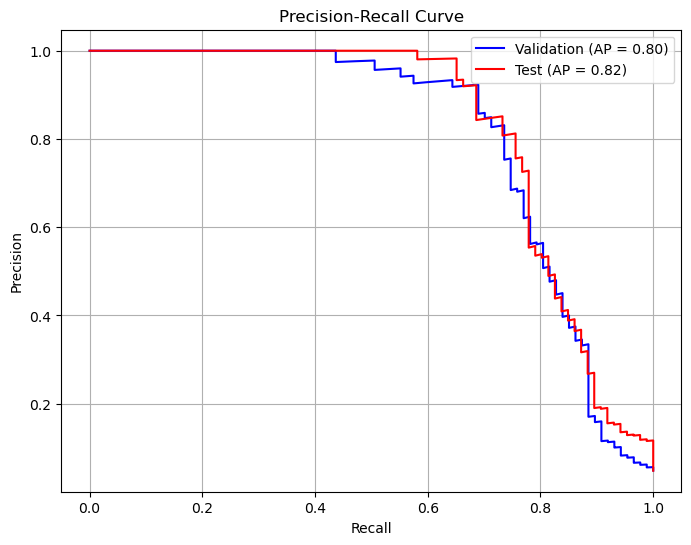

In [70]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Get predicted probabilities for class 1 (fraudulent) from the best model
y_val_probs = best_log_reg_m.predict_proba(X_val_tfidf)[:, 1]
y_test_probs = best_log_reg_m.predict_proba(X_test_tfidf)[:, 1]

# Compute precision-recall curves
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_probs)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_probs)

# Compute average precision scores
avg_precision_val = average_precision_score(y_val, y_val_probs)
avg_precision_test = average_precision_score(y_test, y_test_probs)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall_val, precision_val, label=f"Validation (AP = {avg_precision_val:.2f})", color="blue")
plt.plot(recall_test, precision_test, label=f"Test (AP = {avg_precision_test:.2f})", color="red")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

## XGBoost

In [ ]:
"""# Define the model
xgb_model = XGBClassifier(
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

# Define your hyperparameter search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,  # 👈 your param grid
    n_iter=10,                       # try 10 random combinations
    scoring="average_precision",    # AP score (great for imbalance)
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Run the search on your training data
random_search.fit(X_train_tfidf, y_train)

# Best model and parameters
best_xgb = random_search.best_estimator_
print("Best parameters found:", random_search.best_params_)"""

Fitting 5 folds for each of 10 candidates, totalling 50 fits
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:26:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
Best parameters found: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}

In [72]:
from xgboost import XGBClassifier

# Best parameters from previous tuning
best_xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=1.0,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# Fit model to training data
best_xgb_model.fit(X_train_tfidf, y_train)


D:\Jupyter\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:21:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [76]:
# Use the best model, not the original unfitted one!
y_val_xgb_m = best_xgb_model.predict(X_val_tfidf)
y_test_xgb_m = best_xgb_model.predict(X_test_tfidf)

# Print classification reports
from sklearn.metrics import classification_report

print("\n Validation Set Classification Report:")
print(classification_report(y_val, y_val_xgb_m, target_names=["Real", "Fake"]))

print("\n Test Set Classification Report:")
print(classification_report(y_test, y_test_xgb_m, target_names=["Real", "Fake"]))


 Validation Set Classification Report:
              precision    recall  f1-score   support

        Real       0.98      1.00      0.99      1701
        Fake       0.98      0.63      0.77        87

    accuracy                           0.98      1788
   macro avg       0.98      0.82      0.88      1788
weighted avg       0.98      0.98      0.98      1788


 Test Set Classification Report:
              precision    recall  f1-score   support

        Real       0.98      1.00      0.99      1702
        Fake       1.00      0.55      0.71        86

    accuracy                           0.98      1788
   macro avg       0.99      0.77      0.85      1788
weighted avg       0.98      0.98      0.98      1788



D:\Jupyter\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


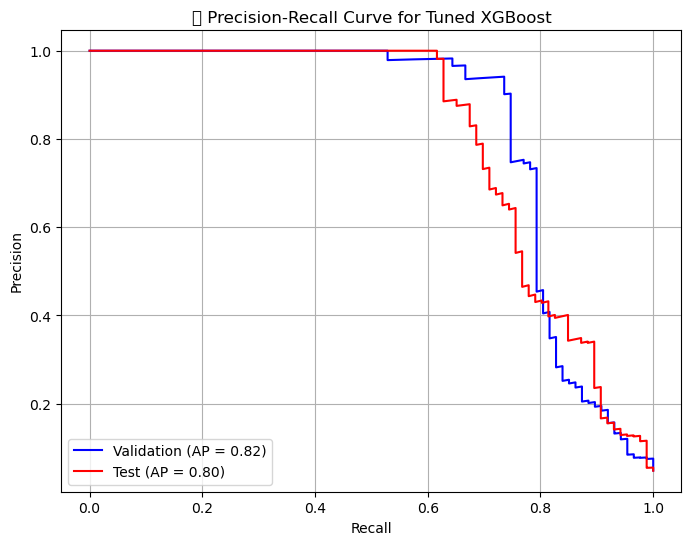

In [78]:
# ✅ Use the tuned model (best_xgb) to get predicted probabilities
y_val_probs = best_xgb_model.predict_proba(X_val_tfidf)[:, 1]
y_test_probs = best_xgb_model.predict_proba(X_test_tfidf)[:, 1]

# Precision-recall curves
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_probs)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_probs)

# Average precision scores
avg_precision_val = average_precision_score(y_val, y_val_probs)
avg_precision_test = average_precision_score(y_test, y_test_probs)

# Plot the precision-recall curves
plt.figure(figsize=(8, 6))
plt.plot(recall_val, precision_val, label=f"Validation (AP = {avg_precision_val:.2f})", color="blue")
plt.plot(recall_test, precision_test, label=f"Test (AP = {avg_precision_test:.2f})", color="red")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("🔹 Precision-Recall Curve for Tuned XGBoost")
plt.legend()
plt.grid(True)
plt.show()

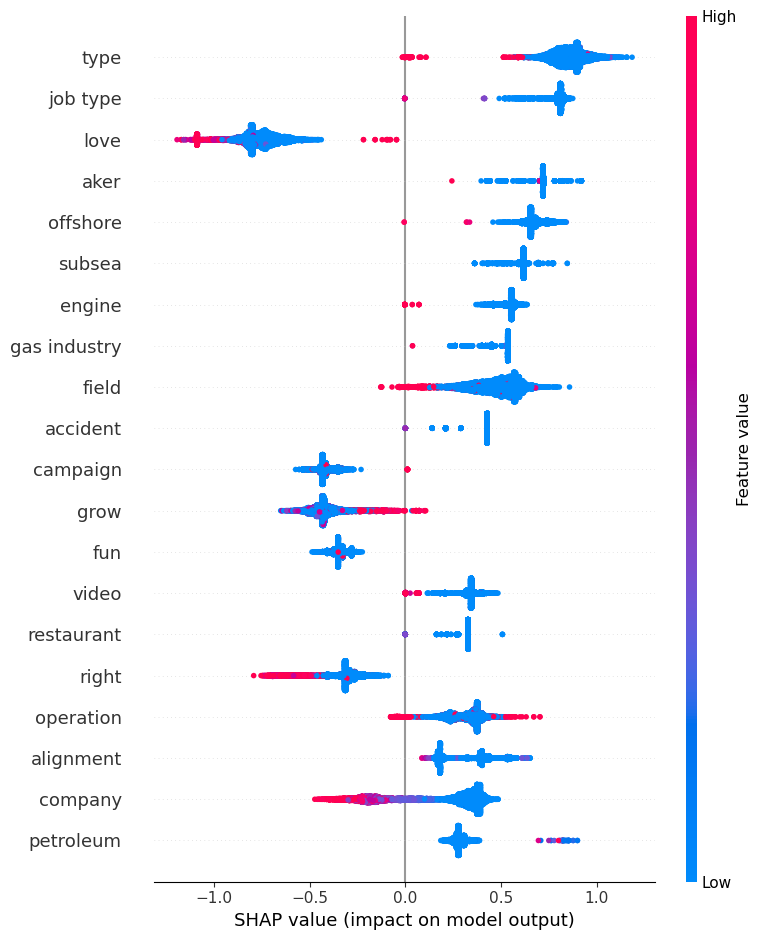

In [84]:
import shap

# Initialize SHAP explainer for the XGBoost model
explainer = shap.TreeExplainer(best_xgb_model)

# Convert TF-IDF sparse matrix to dense
X_train_dense = X_train_tfidf.toarray()

# Compute SHAP values (works in recent SHAP versions)
shap_values = explainer(X_train_dense).values

# SHAP summary plot
shap.summary_plot(
    shap_values,
    X_train_dense,
    feature_names=tfidf_vectorizer.get_feature_names_out()
)

SHAP value shape (decision plot): (5000,)
Feature row shape: (5000,)


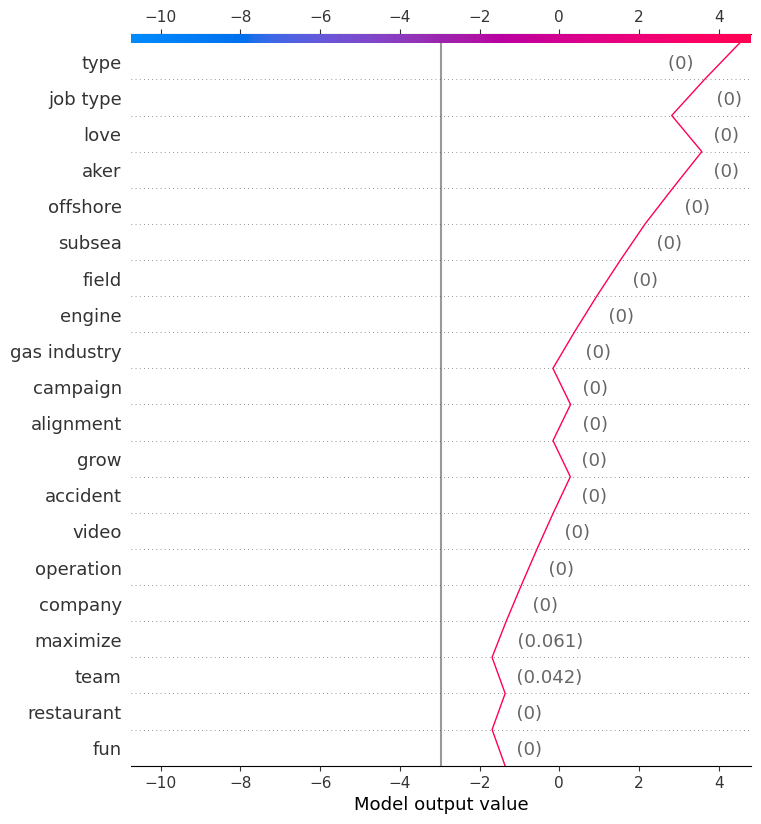

In [88]:
import shap

# Convert sparse matrix to dense format
X_test_dense = X_test_tfidf.toarray()

# SHAP explainer
explainer = shap.TreeExplainer(best_xgb_model)

# Compute SHAP values
shap_result = explainer(X_test_dense)
shap_values = shap_result.values

# Select a sample index
news_idx = min(10, X_test_dense.shape[0] - 1)

# Predict class
predicted_class = best_xgb_model.predict(X_test_dense[[news_idx]])[0]

# Extract SHAP and feature values for the sample
shap_values_sample = shap_values[news_idx, :]
feature_values_sample = X_test_dense[news_idx, :]
expected_value = shap_result.base_values[news_idx]

print(f"SHAP value shape (decision plot): {shap_values_sample.shape}")
print(f"Feature row shape: {feature_values_sample.shape}")

# Decision plot
shap.decision_plot(
    expected_value,
    shap_values_sample.reshape(1, -1),
    feature_values_sample.reshape(1, -1),
    feature_names=tfidf_vectorizer.get_feature_names_out()
)